In [1]:
# Setting the seed here is sufficient. 
# If you don't plan to use these starter code, make sure you add this cell.

SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
# from tensorflow.keras.layers import ...

In [3]:
import pandas as pd
df = pd.read_csv('hdb_price_prediction.csv')
df

,month,year,full_address,nearest_stn,dist_to_nearest_stn,dist_to_dhoby,degree_centrality,eigenvector_centrality,flat_model_type,remaining_lease_years,floor_area_sqm,storey_range,resale_price
0,1,2017,406 ANG MO KIO AVENUE 10,Ang Mo Kio,1.007264,7.006044,0.016807,0.006243,"2 ROOM, Improved",61.333333,44.0,10 TO 12,232000.0
1,1,2017,108 ANG MO KIO AVENUE 4,Ang Mo Kio,1.271389,7.983837,0.016807,0.006243,"3 ROOM, New Generation",60.583333,67.0,01 TO 03,250000.0
2,1,2017,602 ANG MO KIO AVENUE 5,Yio Chu Kang,1.069743,9.090700,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,262000.0
3,1,2017,465 ANG MO KIO AVENUE 10,Ang Mo Kio,0.946890,7.519889,0.016807,0.006243,"3 ROOM, New Generation",62.083333,68.0,04 TO 06,265000.0
4,1,2017,601 ANG MO KIO AVENUE 5,Yio Chu Kang,1.092551,9.130489,0.016807,0.002459,"3 ROOM, New Generation",62.416667,67.0,01 TO 03,265000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
104089,8,2021,710 YISHUN AVENUE 5,Yishun,0.826153,14.410089,0.016807,0.000382,"4 ROOM, New Generation",61.750000,93.0,07 TO 09,390000.0
104090,8,2021,117 YISHUN RING ROAD,Yishun,1.045337,15.215236,0.016807,0.000382,"4 ROOM, Model A",60.916667,104.0,07 TO 09,380000.0
104091,8,2021,453 YISHUN STREET 41,Khatib,1.424543,13.350952,0.016807,0.000968,"4 ROOM, Model A",91.083333,93.0,04 TO 06,433000.0
104092,8,2021,505D YISHUN STREET 51,Khatib,1.259536,13.232993,0.016807,0.000968,"4 ROOM, Model A",93.666667,93.0,01 TO 03,460000.0


In [4]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("resale_price")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = tf.keras.layers.Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode="one_hot") # NOTE: as mentioned in the question paper, this actually does one-hot encoding. You could replace 'binary' with 'one_hot' if you wish to.

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature


# Q1

Columns to be used in network

In [5]:
numerical_features = [
    'dist_to_nearest_stn',
    'dist_to_dhoby',
    'degree_centrality',
    'eigenvector_centrality',
    'remaining_lease_years',
    'floor_area_sqm'
]
categorical_string = [
    'flat_model_type',
    'storey_range'
]
categorical_non_string = [
    'month'
]

The aim is to predict future prices with pasts price data. If random train/valid is used, the future target prices (2021) will also be present in the train set.

This is inherently wrong as:
- instead of learning trends in past price data and extending these trends to future data
- the model would be learning future data trends from the train set (in a sense cheating)

In [6]:
#Split data
train_dataframe = df[df['year'] <= 2020]
val_dataframe = df[df['year'] >= 2021]
train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)

train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)

2021-09-21 14:49:55.085546: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Helper functions:

- `prep_inputs`
    - encode numerical and categorical features respectively
    - can specify embedding layer for categorical features
    
- `r_squared`
    - compute r sqaured between inferred and target `resale_price`

- `make_network`
    - clears tf session
    - can specify `drop`
        - will collect input layers and features not in `drop`
    - concatenate features
    - build question specified model
    - returns visualization of model and model
    
- `run_network`
    - wrapper to run `model.fit` for training

In [7]:
def prep_inputs(embedding=False):
    all_inputs = []
    all_features = []
    for col in df.columns:
        append = False
        if col in numerical_features:
            feature = tf.keras.layers.Input((1,), name=col)
            encoded_feature = encode_numerical_feature(feature, col, train_ds)
            append = True
            
        elif col in categorical_string + categorical_non_string:
            is_string = col in categorical_string
            feature = tf.keras.layers.Input((1,), name=col, dtype='string' if is_string else 'int64')
            encoded_feature = encode_categorical_feature(feature, col, train_ds, is_string)
            if embedding:
                input_dim = len(df[col].unique())
                encoded_feature = tf.keras.layers.Embedding(input_dim, input_dim // 2)(encoded_feature)
                encoded_feature = tf.keras.layers.Flatten()(encoded_feature)
            append = True
            
        if append:
            all_inputs.append(feature)
            all_features.append(encoded_feature)

    return all_inputs, all_features

def r_squared(y, y_pred):
    residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

def make_network(all_inputs, all_features, drop=[]):
    tf.keras.backend.clear_session() # clear tf session

    inputs = [all_inputs[i] for i in range(len(all_inputs)) if i not in drop]
    features = [all_features[i] for i in range(len(all_features)) if i not in drop]
    
    print(f'current {len(inputs)} inputs:\n\t' +
          '\n\t'.join(inpt.name for inpt in inputs) + '\n')
    
    features = tf.keras.layers.concatenate(features)
    x = layers.Dense(10, activation="relu")(features)
    output = layers.Dense(1)(x)
    model = keras.Model(inputs, output)
    model.compile(tf.keras.optimizers.Adam(.05), "mse", metrics=[r_squared])
    return tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR"), model
    
def run_network(
    model,
    train_ds=train_ds,
    epochs=100,
    batch_size=128,
    validation_data=val_ds,
    callbacks=[],
    verbose=1
):
    return model.fit(
        train_ds,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=val_ds,
        callbacks=callbacks,
        verbose=verbose
    )

current 9 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



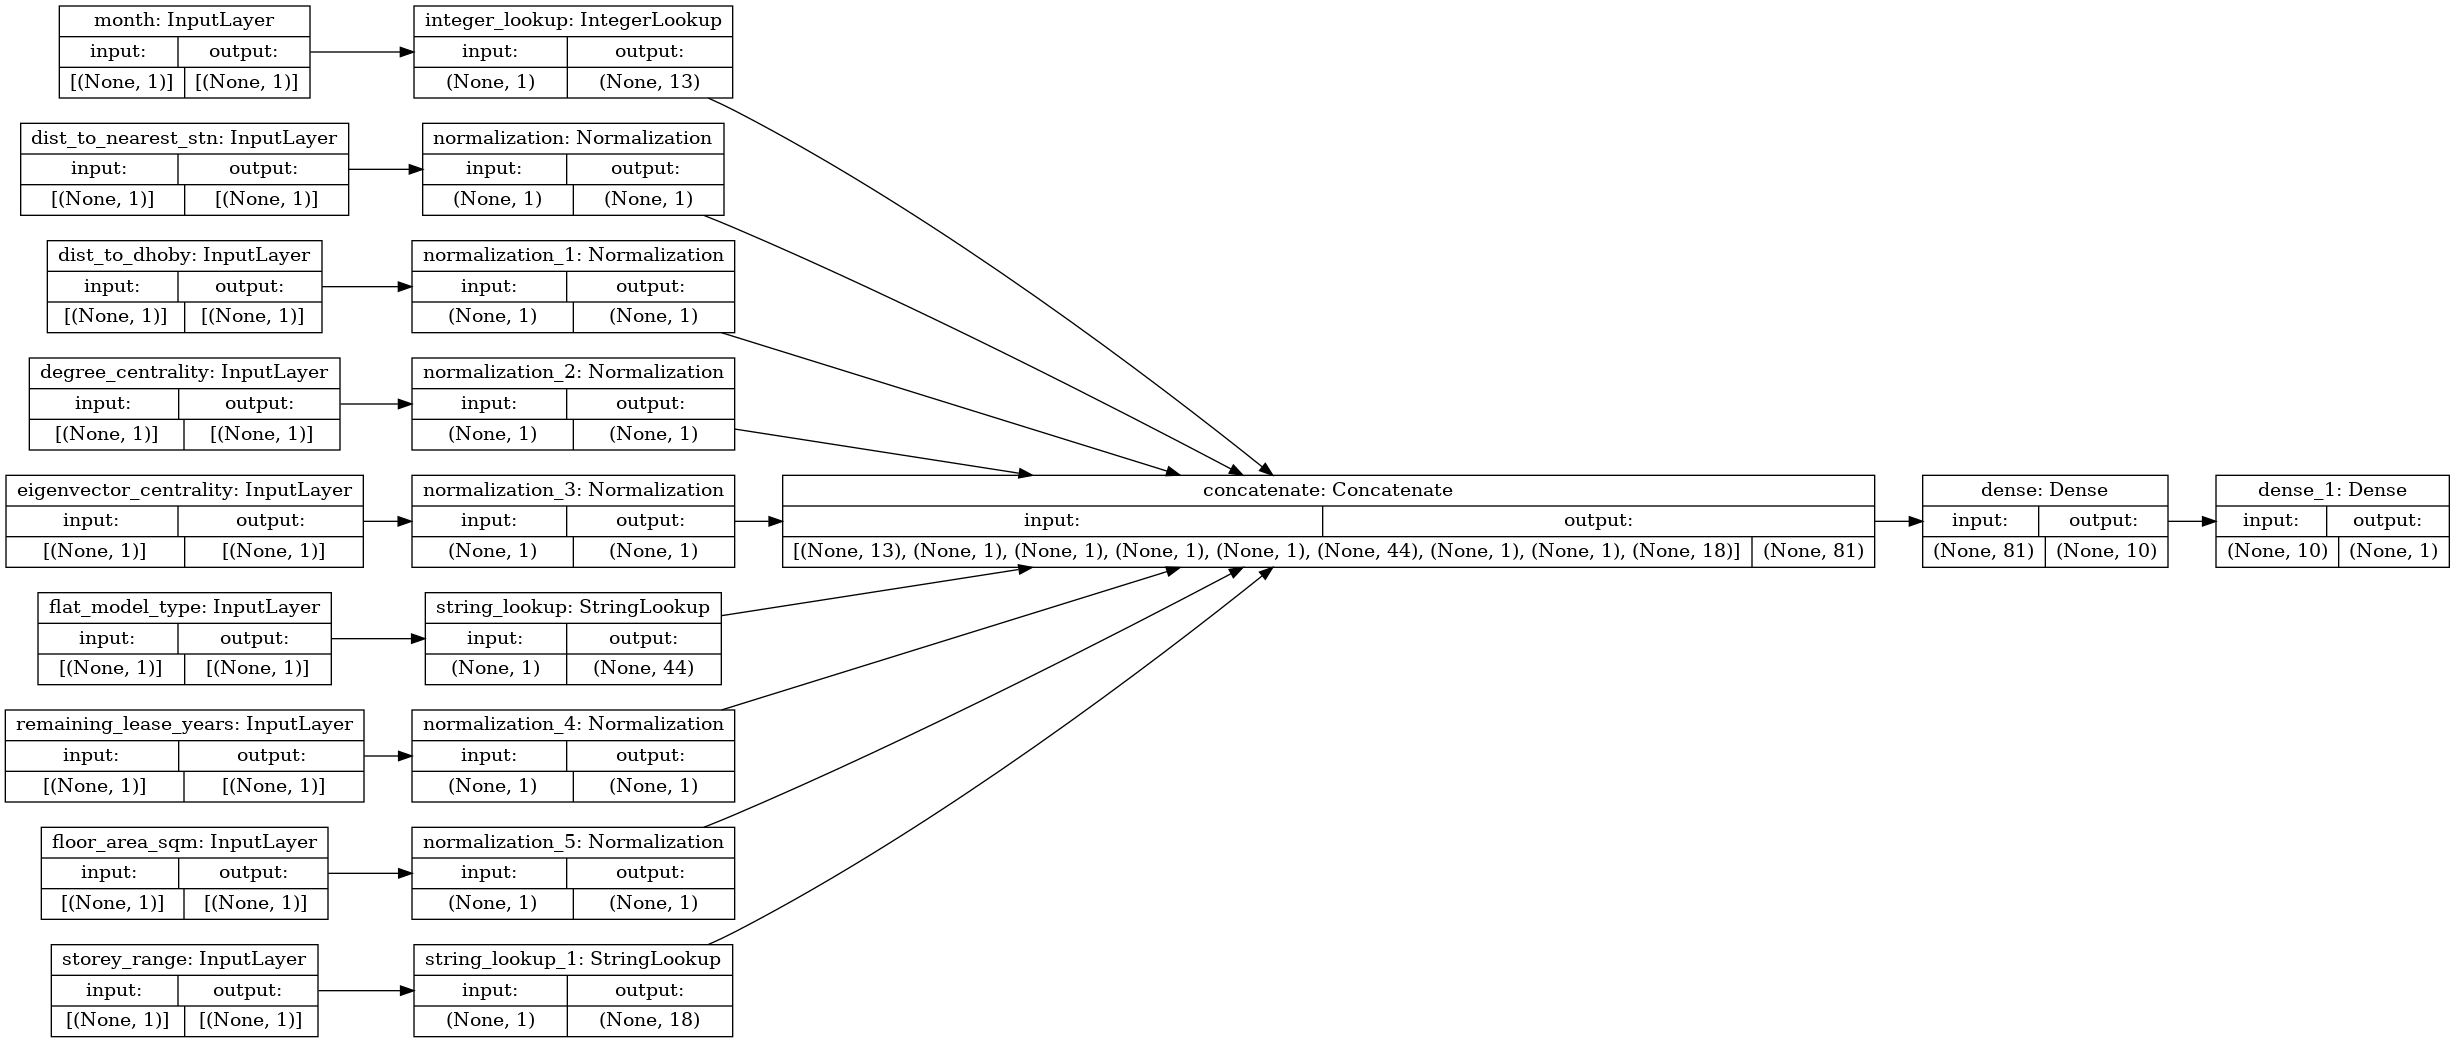

In [8]:
# only use this callback to restore weights
# not to stop early
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    patience=100, 
    restore_best_weights=True,
)]

all_inputs, all_features = prep_inputs()
visualization, model = make_network(all_inputs, all_features)
visualization

In [9]:
%%time
q1 = run_network(
    model,
    callbacks=callbacks
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 4ms/step - loss: 187224227840.0000 - r_squared: -7.0504 - val_loss: 170861576192.0000 - val_r_squared: -5.7026
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 67241811968.0000 - r_squared: -1.8816 - val_loss: 39794077696.0000 - val_r_squared: -0.5491
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 10806155264.0000 - r_squared: 0.5421 - val_loss: 11001638912.0000 - val_r_squared: 0.5750
Epoch 4/100
683/683 [==============================] - 3s 3ms/step - loss: 5529835520.0000 - r_squared: 0.7648 - val_loss: 8573706240.0000 - val_r_squared: 0.6690
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 4987972096.0000 - r_squared: 0.7872 - val_loss: 7977381888.0000 - val_r_squared: 0.6912
Epoch 6/100
683/683 [==============================] - 3s 3ms/step - loss: 4625119232.0000 - r_squared: 0.8025 - val_loss: 7678292480.0000 - val_r_squared: 0.7038
Epoch 7/100
683/683 [=

683/683 [==============================] - 3s 4ms/step - loss: 2748985344.0000 - r_squared: 0.8816 - val_loss: 5209585152.0000 - val_r_squared: 0.7965
Epoch 52/100
683/683 [==============================] - 3s 4ms/step - loss: 2746192384.0000 - r_squared: 0.8815 - val_loss: 5045279744.0000 - val_r_squared: 0.8035
Epoch 53/100
683/683 [==============================] - 3s 4ms/step - loss: 2744288000.0000 - r_squared: 0.8818 - val_loss: 5291627520.0000 - val_r_squared: 0.7930
Epoch 54/100
683/683 [==============================] - 3s 4ms/step - loss: 2742368512.0000 - r_squared: 0.8819 - val_loss: 5288608768.0000 - val_r_squared: 0.7927
Epoch 55/100
683/683 [==============================] - 3s 4ms/step - loss: 2740502272.0000 - r_squared: 0.8816 - val_loss: 5024320000.0000 - val_r_squared: 0.8034
Epoch 56/100
683/683 [==============================] - 3s 4ms/step - loss: 2739045632.0000 - r_squared: 0.8821 - val_loss: 5145970688.0000 - val_r_squared: 0.7987
Epoch 57/100
683/683 [=======

In [10]:
import matplotlib.pyplot as plt
def plot_accuracy(history, truncate=2, suptitle_label=''):
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    f.subplots_adjust(top=.75 if suptitle_label == '' else .7)
    
    def scale_history(values, sqrt=False, truncate=truncate):
        if sqrt:
            values = list(np.sqrt(values))
        return [values[truncate]] * truncate + values[truncate:]

    r_squared = scale_history(history['r_squared'])
    loss = scale_history(history['loss'], True) # rmse
    val_r_squared = scale_history(history['val_r_squared'])
    val_loss = scale_history(history['val_loss'], True) # rmse
    
    axes[1].plot(r_squared)
    axes[1].plot(val_r_squared)
    axes[1].set_title('Model r_squared')
    axes[1].set(ylabel = 'r_squared', xlabel = 'Epoch')
    axes[1].legend(['Train', 'Valid'], loc='upper left')
    axes[0].plot(loss)
    axes[0].plot(val_loss)
    axes[0].set_title('Model loss')
    axes[0].set(ylabel = 'Loss (RMSE)', xlabel = 'Epoch')
    axes[0].legend(['Train', 'Valid'], loc='upper left')
    
    title = (
        suptitle_label +
        'Min Training loss (RMSE): {:.{}f}\n'.format(min(loss), 3) +
        'Max Training r_squared: {:.{}f}\n'.format(max(r_squared), 3) +
        'Min Validation loss (RMSE): {:.{}f}\n'.format(min(val_loss), 3) +
        'Max Validation r_squared: {:.{}f}\n'.format(max(val_r_squared), 3)
    )
    f.suptitle(title)
    axes[0].set_xlim((truncate, 100))
    axes[1].set_xlim((truncate, 100))

- large divergence
    - overfitting

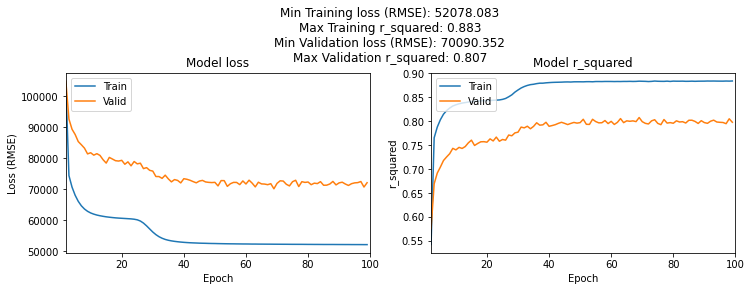

In [11]:
plot_accuracy(q1.history)

In [12]:
index = np.argmin(q1.history['val_loss']) # lowest validation mse error
print(f'epoch {index} has lowest mse of {round(q1.history["val_r_squared"][index], 3)}')

epoch 69 has lowest mse of 0.807


model is already loaded with best weights due to `EarlyStopping`

In [13]:
for x, targets in val_ds.take(1).as_numpy_iterator():
    break
preds = model.predict(x)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


plot generally follows line `y = x` which is good
- suggests that model has somewhat learnt to predict validation `resale_prices`

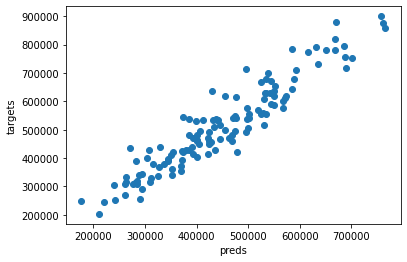

In [14]:
plt.scatter(preds, targets)
plt.xlabel('preds')
plt.ylabel('targets');

# Q2

add `Embedding` layer for categorical features

current 9 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



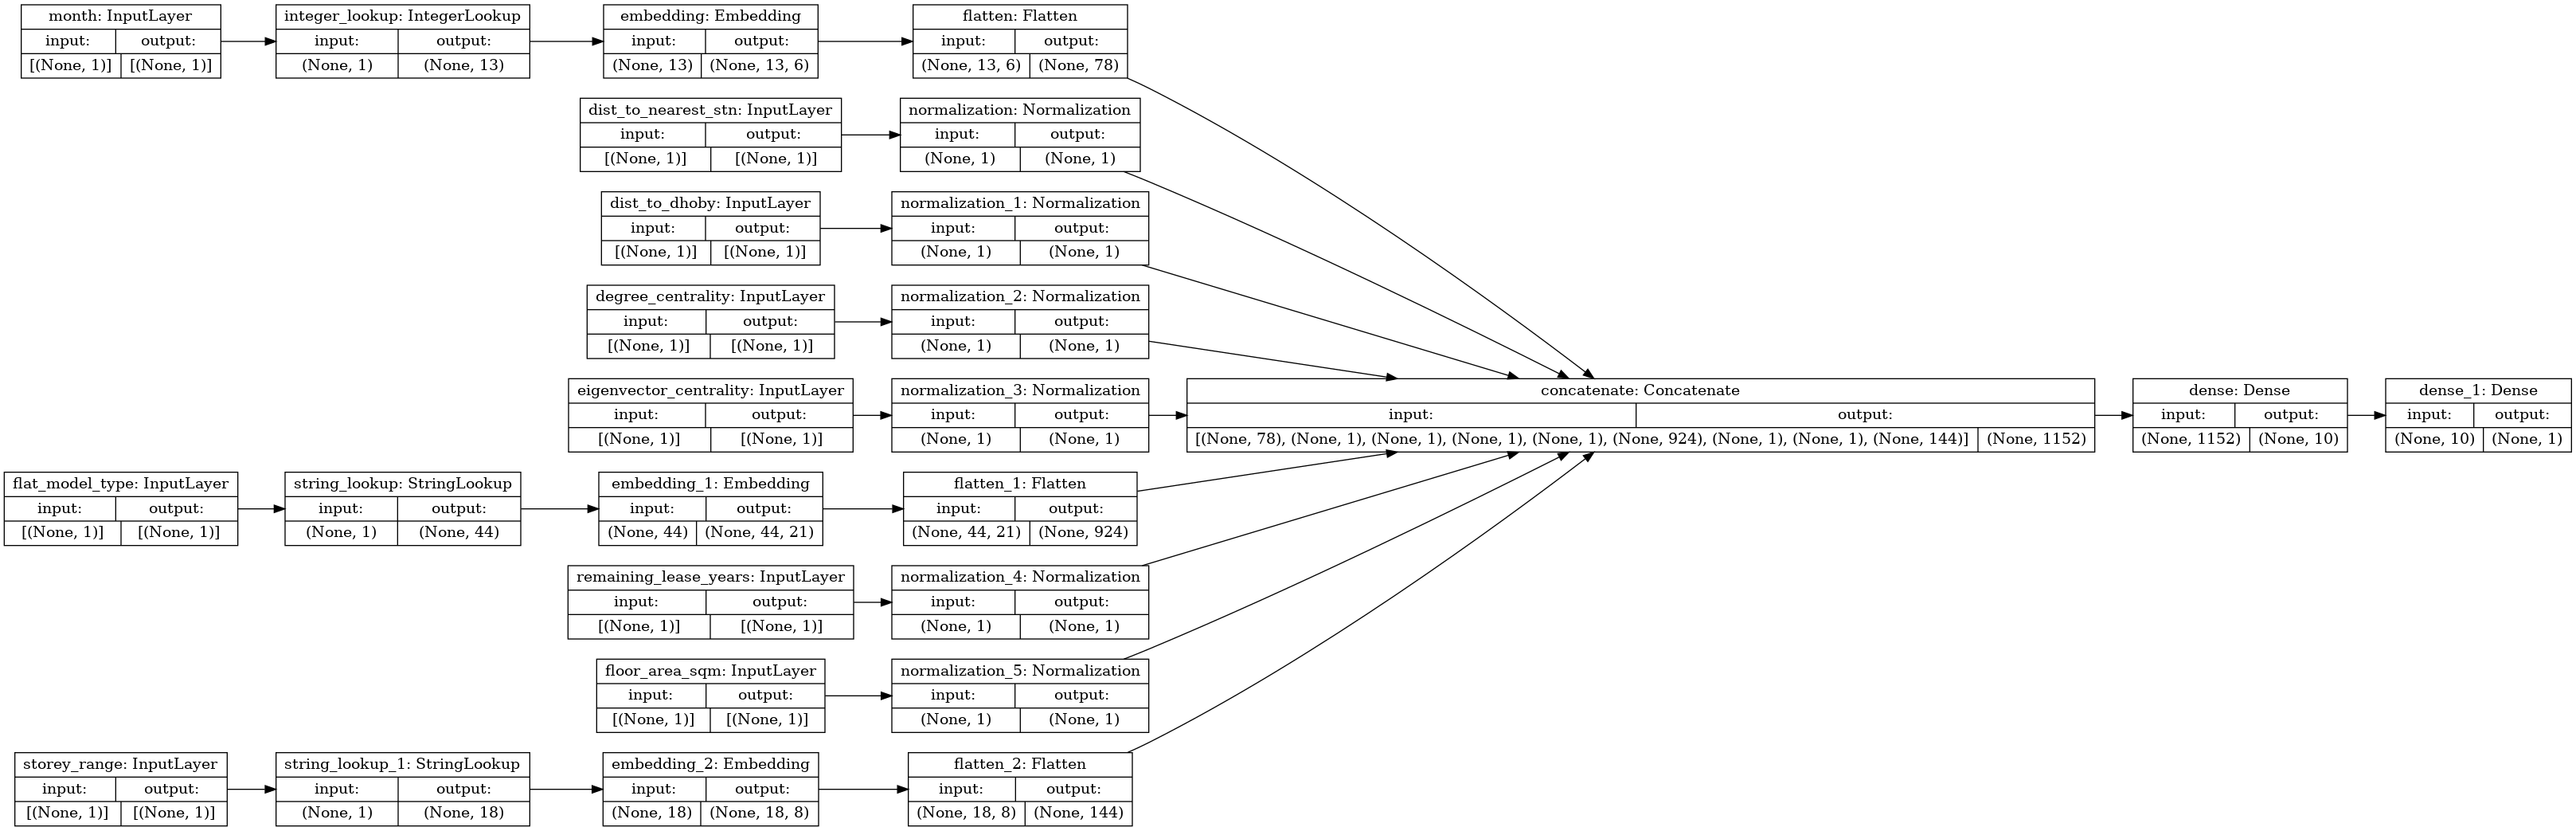

In [15]:
all_inputs, all_features = prep_inputs(embedding=True)
visualization, model = make_network(all_inputs, all_features)
visualization

In [16]:
%%time
q2 = run_network(
    model,
    callbacks=callbacks
)

Epoch 1/100
683/683 [==============================] - 4s 4ms/step - loss: 36594135040.0000 - r_squared: -0.5530 - val_loss: 27691972608.0000 - val_r_squared: -0.0665
Epoch 2/100
683/683 [==============================] - 3s 3ms/step - loss: 14710512640.0000 - r_squared: 0.3753 - val_loss: 11827246080.0000 - val_r_squared: 0.5450
Epoch 3/100
683/683 [==============================] - 3s 3ms/step - loss: 8616940544.0000 - r_squared: 0.6324 - val_loss: 10993692672.0000 - val_r_squared: 0.5733
Epoch 4/100
683/683 [==============================] - 3s 3ms/step - loss: 7529049600.0000 - r_squared: 0.6777 - val_loss: 9634856960.0000 - val_r_squared: 0.6275
Epoch 5/100
683/683 [==============================] - 3s 3ms/step - loss: 6824319488.0000 - r_squared: 0.7081 - val_loss: 9661271040.0000 - val_r_squared: 0.6256
Epoch 6/100
683/683 [==============================] - 3s 3ms/step - loss: 6183950848.0000 - r_squared: 0.7353 - val_loss: 7363419648.0000 - val_r_squared: 0.7146
Epoch 7/100
683

Epoch 51/100
683/683 [==============================] - 3s 3ms/step - loss: 2672200960.0000 - r_squared: 0.8847 - val_loss: 4851767296.0000 - val_r_squared: 0.8096
Epoch 52/100
683/683 [==============================] - 3s 3ms/step - loss: 2671418112.0000 - r_squared: 0.8850 - val_loss: 5345485312.0000 - val_r_squared: 0.7911
Epoch 53/100
683/683 [==============================] - 3s 3ms/step - loss: 2669877760.0000 - r_squared: 0.8847 - val_loss: 4815694848.0000 - val_r_squared: 0.8118
Epoch 54/100
683/683 [==============================] - 3s 4ms/step - loss: 2660021504.0000 - r_squared: 0.8854 - val_loss: 5451067904.0000 - val_r_squared: 0.7867
Epoch 55/100
683/683 [==============================] - 3s 3ms/step - loss: 2665838080.0000 - r_squared: 0.8850 - val_loss: 5447566336.0000 - val_r_squared: 0.7867
Epoch 56/100
683/683 [==============================] - 3s 3ms/step - loss: 2660616448.0000 - r_squared: 0.8852 - val_loss: 4906947584.0000 - val_r_squared: 0.8079
Epoch 57/100
683

CPU times: user 8min 47s, sys: 43.1 s, total: 9min 30s
Wall time: 4min 34s


Observations:
- adding `Embedding()` improves performance
    - `RMSE` decreases
    - `R_Squared` increases
    - divergence decreases
        - weights learnt in `train` are more generalizable to `valid`
   
Insights:
- `Embedding()` allows for encoding of more information and thus leads to better performance
    - eg, instead of `0 1 0 # storey range 4-6`, `0.3 0.1 0` where `0.3` could represent the scale of height (0-1) and `0.1` could represent other information 

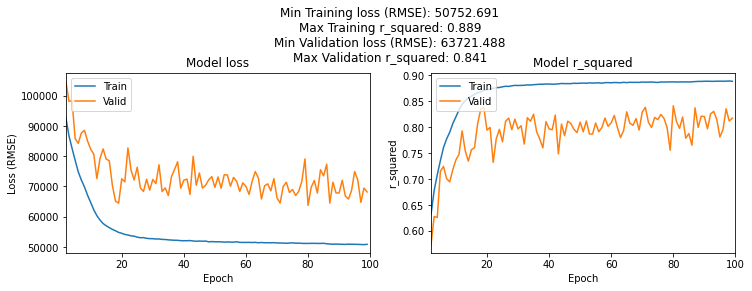

In [17]:
plot_accuracy(q2.history)

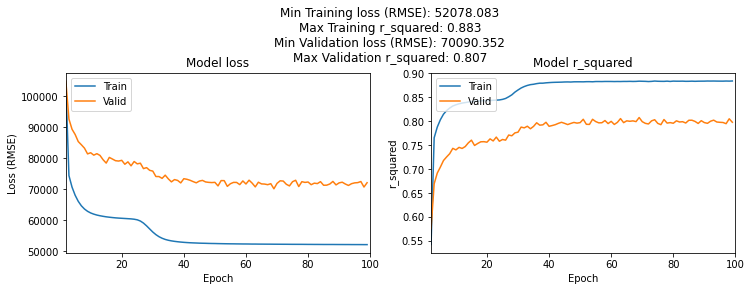

In [18]:
plot_accuracy(q1.history)

# Q3

In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    patience=10, 
    restore_best_weights=True,
)]

In [20]:
def recursive_feature_elimination(
    callbacks,
    baseline,
    all_inputs,
    all_features,
):
    inputs = [x for x in all_inputs]
    features = [x for x in all_features]
    # init 8 row x 9 col to be converted to dataframe later
    # 9 features and 8 iterations of choosing which to drop
    val_loss_memory = {f'w/o_{x.name}': [np.inf] * 9 for x in inputs}
    
    for row in range(len(inputs) - 1):
        differences = []
        # repeat k times to decide which feature to drop
        for col in range(len(inputs)):
            print(f'Popping {inputs[col].name}')
            visualization, model = make_network(inputs, features, drop=[col])
            history = run_network(
                model,
                callbacks=callbacks,
                verbose=0
            )
            
            val_loss = min(history.history['val_loss'])
            val_loss_memory[f'w/o_{inputs[col].name}'][row] = val_loss
            differences.append(val_loss - baseline)
            
        differences = np.array(differences)
        # no improvement (all val loss > baseline)
        if not np.sum(differences < 0):
            break
        # max increase in performance
        to_drop = np.argmax(np.where(differences < 0, differences, np.zeros(differences.shape)))
                
        to_drop_name = inputs[to_drop].name
        print(f'\nsmallest change: {to_drop_name}\n')
        inputs.pop(to_drop)
        features.pop(to_drop)
        
#         # if new iteration does not yield better score than previous iterations
#         # no need to continue RFE; best solution found
#         if row != 0:
#             df = pd.DataFrame.from_dict(val_loss_memory)
#             latest_iteration = df.iloc[-1:]
#             previous_iterations = df.iloc[:-1]
#             if np.min(latest_iteration.values) > np.min(previous_iterations.values.flatten()):
#                 break
    
    # apply sqrt to get rmse
    val_loss_memory = pd.DataFrame.from_dict(val_loss_memory).apply(lambda x: round(np.sqrt(x)))
    val_loss_memory.iloc[-1] = val_loss_memory.iloc[-2].values
    val_loss_memory.iloc[-1][f'w/o_{to_drop_name}'] = np.inf
    
    return val_loss_memory

In [21]:
%%time
val_loss_memory = recursive_feature_elimination(
    callbacks=callbacks,
    baseline=min(q2.history['val_loss']),
    all_inputs=all_inputs,
    all_features=all_features)

Popping month
current 8 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_nearest_stn
current 8 inputs:
	month
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_dhoby
current 8 inputs:
	month
	dist_to_nearest_stn
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping degree_centrality
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping eigenvector_centrality
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping flat_model_type
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping remaining_lease_years
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping floor_area_sqm
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping storey_range
current 8 inputs:
	month
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



smallest change: month

Popping dist_to_nearest_stn
current 7 inputs:
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping dist_to_dhoby
current 7 inputs:
	dist_to_nearest_stn
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'dist_to_dhoby'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping degree_centrality
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'degree_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping eigenvector_centrality
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'eigenvector_centrality'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping flat_model_type
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	remaining_lease_years
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'flat_model_type'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping remaining_lease_years
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	floor_area_sqm
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'remaining_lease_years'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping floor_area_sqm
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	storey_range



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'floor_area_sqm'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Popping storey_range
current 7 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn', 'storey_range'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])



smallest change: degree_centrality

CPU times: user 48min, sys: 4min 20s, total: 52min 21s
Wall time: 25min 38s


- column represents RMSE for a run without column name
- row represents each iteration of removing feature that impacts performance the least
- `inf` values denote that this particular feature is already removed during this iteration

e.g:

| w/o_month
| ---
| 62362.0
| inf

denotes RMSE for training without feature `month`, resulting in loss of `62362.0` on the first iteration
- since this happens to be the smallest change in loss from benchmark RMSE in Q2, this is dropped and is thus `inf` on iteration 2

In [22]:
val_loss_memory

,w/o_month,w/o_dist_to_nearest_stn,w/o_dist_to_dhoby,w/o_degree_centrality,w/o_eigenvector_centrality,w/o_flat_model_type,w/o_remaining_lease_years,w/o_floor_area_sqm,w/o_storey_range
0,62362.0,70659.0,86455.0,67451.0,67849.0,77912.0,71854.0,72222.0,70748.0
1,inf,77557.0,80547.0,63992.0,64879.0,70708.0,70305.0,68550.0,67556.0
2,inf,inf,inf,inf,inf,inf,inf,inf,inf
3,inf,inf,inf,inf,inf,inf,inf,inf,inf
4,inf,inf,inf,inf,inf,inf,inf,inf,inf
5,inf,inf,inf,inf,inf,inf,inf,inf,inf
6,inf,inf,inf,inf,inf,inf,inf,inf,inf
7,inf,inf,inf,inf,inf,inf,inf,inf,inf
8,inf,inf,inf,inf,inf,inf,inf,inf,inf


threshold Q2 `val_loss` to find which combination of features yields the lowest `val_loss` (best performer)
- training without `month` as a feature results in best performance
    - lowest RMSE

In [23]:
val_loss_memory.apply(lambda x: x < 63721.488)

,w/o_month,w/o_dist_to_nearest_stn,w/o_dist_to_dhoby,w/o_degree_centrality,w/o_eigenvector_centrality,w/o_flat_model_type,w/o_remaining_lease_years,w/o_floor_area_sqm,w/o_storey_range
0,True,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False


train without `month` but for full 100 epochs for fairer comparison with Q2 results

current 8 inputs:
	dist_to_nearest_stn
	dist_to_dhoby
	degree_centrality
	eigenvector_centrality
	flat_model_type
	remaining_lease_years
	floor_area_sqm
	storey_range



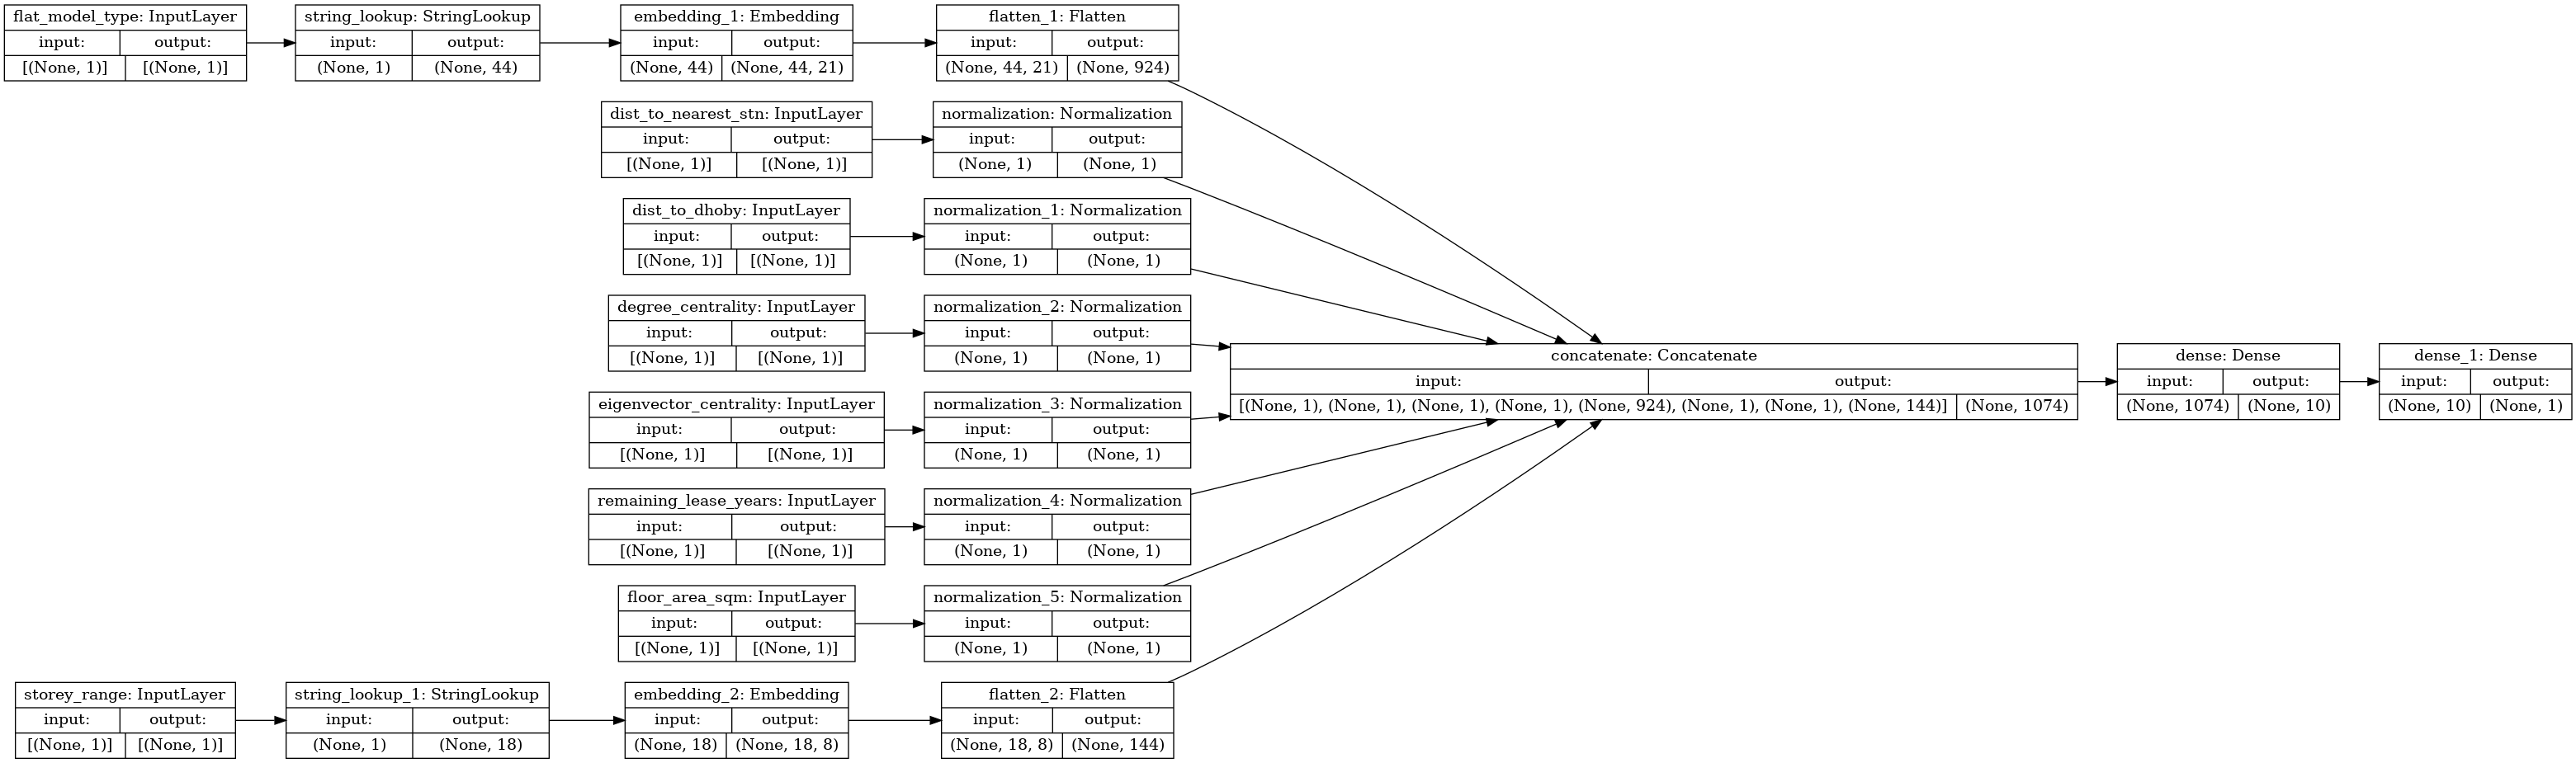

In [24]:
# only use this callback to restore weights
# not to stop early
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    patience=100, 
    restore_best_weights=True,
)]

# drop month
visualization, model = make_network(all_inputs, all_features, drop=[0])
visualization

In [25]:
%%time
q3 = run_network(
    model,
    callbacks=callbacks,
)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:585: UserWarning: Input dict contained keys ['month', 'year', 'full_address', 'nearest_stn'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


683/683 [==============================] - 4s 4ms/step - loss: 26070130688.0000 - r_squared: -0.1054 - val_loss: 12480624640.0000 - val_r_squared: 0.5200
Epoch 2/100
683/683 [==============================] - 3s 4ms/step - loss: 8752074752.0000 - r_squared: 0.6266 - val_loss: 11219661824.0000 - val_r_squared: 0.5651
Epoch 3/100
683/683 [==============================] - 3s 4ms/step - loss: 7686845440.0000 - r_squared: 0.6715 - val_loss: 8790391808.0000 - val_r_squared: 0.6593
Epoch 4/100
683/683 [==============================] - 3s 4ms/step - loss: 6930381312.0000 - r_squared: 0.7035 - val_loss: 8431701504.0000 - val_r_squared: 0.6724
Epoch 5/100
683/683 [==============================] - 3s 4ms/step - loss: 6225505792.0000 - r_squared: 0.7336 - val_loss: 8185553408.0000 - val_r_squared: 0.6823
Epoch 6/100
683/683 [==============================] - 4s 4ms/step - loss: 5581885952.0000 - r_squared: 0.7610 - val_loss: 6852641280.0000 - val_r_squared: 0.7335
Epoch 7/100
683/683 [=========

683/683 [==============================] - 3s 3ms/step - loss: 2615773440.0000 - r_squared: 0.8870 - val_loss: 5502644736.0000 - val_r_squared: 0.7854
Epoch 52/100
683/683 [==============================] - 3s 3ms/step - loss: 2616785152.0000 - r_squared: 0.8871 - val_loss: 5720604672.0000 - val_r_squared: 0.7755
Epoch 53/100
683/683 [==============================] - 3s 3ms/step - loss: 2610778112.0000 - r_squared: 0.8873 - val_loss: 5349832704.0000 - val_r_squared: 0.7895
Epoch 54/100
683/683 [==============================] - 3s 3ms/step - loss: 2609095168.0000 - r_squared: 0.8877 - val_loss: 5015327744.0000 - val_r_squared: 0.8040
Epoch 55/100
683/683 [==============================] - 3s 4ms/step - loss: 2600962560.0000 - r_squared: 0.8880 - val_loss: 4223363840.0000 - val_r_squared: 0.8345
Epoch 56/100
683/683 [==============================] - 3s 3ms/step - loss: 2610165760.0000 - r_squared: 0.8874 - val_loss: 4685970432.0000 - val_r_squared: 0.8161
Epoch 57/100
683/683 [=======

- with RFE, loss and r_square outperform the model from Q2 (with all the features)

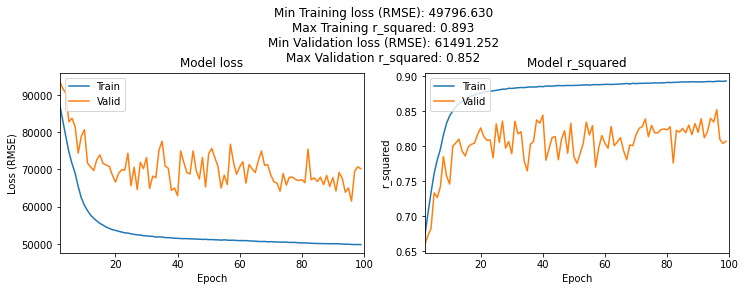

In [26]:
plot_accuracy(q3.history)

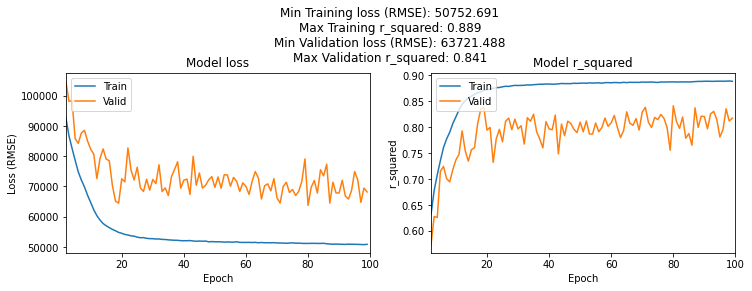

In [27]:
plot_accuracy(q2.history)